In [102]:
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt

In [104]:
bog = pd.read_csv('bog.csv')

In [105]:
bog.fillna('', inplace=True)

In [106]:
def to_date(string):
    if string != '':
        return datetime.datetime.strptime(string, '%m-%d-%Y')
    return datetime.datetime.today()

In [107]:
def make_member_dict():
    members = {}

    for i, row in bog.iterrows():
        new = [to_date(row['start']), to_date(row['end'])]
        name = row['lname']
        if name in members:
            members[name].append(new)
        else:
            members[name] = [new]
    return members

In [108]:
make_member_dict()

{'kugler': [[datetime.datetime(2023, 9, 13, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 645788)]],
 'barr': [[datetime.datetime(2022, 7, 19, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 646198)]],
 'jefferson': [[datetime.datetime(2022, 5, 23, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 646536)]],
 'cook': [[datetime.datetime(2022, 5, 23, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 646853)]],
 'waller': [[datetime.datetime(2020, 12, 18, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 647177)]],
 'bowman': [[datetime.datetime(2018, 11, 26, 0, 0),
   datetime.datetime(2024, 2, 29, 15, 12, 39, 647805)]],
 'clarida': [[datetime.datetime(2018, 9, 17, 0, 0),
   datetime.datetime(2022, 1, 14, 0, 0)]],
 'quarles': [[datetime.datetime(2017, 9, 17, 0, 0),
   datetime.datetime(2021, 12, 25, 0, 0)]],
 'brainard': [[datetime.datetime(2014, 6, 16, 0, 0),
   datetime.datetime(2023, 2, 18, 0, 0)]],
 'fischer': [[datetime.datetime(2014, 5, 28, 0, 0),
   datetime.

In [109]:
prdf = pd.read_csv('presidents.csv')
prdf.fillna({'Out': '', 'Interim': 0}, inplace=True)
prdf.tail()

,Name,Bank,In,Out,Interim
50,Lawrence K. Roos,St. Louis,03/22/1976,01-31-1983,0.0
51,Theodore H. Roberts,St. Louis,02/01/1983,12-31-1984,0.0
52,Thomas C. Melzer,St. Louis,06/01/1985,01-30-1998,0.0
53,William Poole,St. Louis,03/23/1998,01-31-2008,0.0
54,James Bullard,St. Louis,04/01/2008,08-14-2023,0.0


In [110]:
def lname_extract(full_name):
    name_arr = [part.lower() for part in full_name.split(' ')]
    if name_arr[-1] == 'jr.':
        name_arr = name_arr[:-1]
    return name_arr[-1]

In [111]:
prdf['lname'] = prdf['Name'].apply(lname_extract)

In [112]:
prdf.tail()

,Name,Bank,In,Out,Interim,lname
50,Lawrence K. Roos,St. Louis,03/22/1976,01-31-1983,0.0,roos
51,Theodore H. Roberts,St. Louis,02/01/1983,12-31-1984,0.0,roberts
52,Thomas C. Melzer,St. Louis,06/01/1985,01-30-1998,0.0,melzer
53,William Poole,St. Louis,03/23/1998,01-31-2008,0.0,poole
54,James Bullard,St. Louis,04/01/2008,08-14-2023,0.0,bullard


Voting member schedule

In [113]:
vm_schedule = [
    {'bank': 'St. Louis', 'start': 1980, 'interval': 3},
    {'bank': 'Boston', 'start': 1980, 'interval': 3},
    {'bank': 'Philadelphia', 'start': 1981, 'interval': 3},
    {'bank': 'Richmond', 'start': 1982, 'interval': 3},
    {'bank': 'Cleveland', 'start': 1980, 'interval': 2},
    {'bank': 'Chicago', 'start': 1981, 'interval': 2},
    {'bank': 'Atlanta', 'start': 1979, 'interval': 3},
    {'bank': 'Dallas', 'start': 1981, 'interval': 3},
    {'bank': 'Minneapolis', 'start': 1981, 'interval': 3},
    {'bank': 'Kansas City', 'start': 1980, 'interval': 3},
    {'bank': 'San Francisco', 'start': 1979, 'interval': 3},
    {'bank': 'New York', 'start': 1980, 'interval': 1},
]

In [114]:
def which_bank_votes(year):
    voters = []
    for bank in vm_schedule:
        if (year - bank['start']) % bank['interval'] == 0:
            voters.append(bank['bank'])
    return voters

In [115]:
which_bank_votes(2022)

['St. Louis', 'Boston', 'Cleveland', 'Kansas City', 'New York']

In [116]:
def get_pres(region, date):
    for i, row in prdf[prdf['Bank'] == region].iterrows():
        range = pd.period_range(row.In, to_date(row.Out))
        if date in range:
            return row.lname
    return f'{region}-{date}'

In [117]:
def get_bog(date):
    bog_members = []
    for i, row in bog.iterrows():
        range = pd.period_range(row.start, to_date(row.end))
        if date in range:
            bog_members.append(row.lname)
    return bog_members

In [118]:
regions = ['Richmond', 'Philadelphia', 'San Francisco', 'St. Louis', 'Cleveland',
           'Chicago', 'Boston', 'Minneapolis', 'Atlanta', 'Dallas', 'New York', 'Kansas City']

[get_pres(region, '02-13-18') for region in regions] + get_bog('02-13-18')

['barkin',
 'harker',
 'williams',
 'bullard',
 'mester',
 'evans',
 'rosengren',
 'kashkari',
 'bostic',
 'kaplan',
 'dudley',
 'george',
 'quarles',
 'brainard',
 'powell']

In [119]:
def get_fomc(date):
    return [get_pres(region, date) for region in regions] + get_bog(date)

In [120]:
dates = pd.read_csv('../working-csvs/raw_transcripts_sectioned.csv')['date'].unique()

In [121]:
records = []

for date in dates:
    year = int(date.split('-')[0])
    voting_regions = set(which_bank_votes(year))
    nonvoting_regions = set(regions) - set(voting_regions)
    voting_pres = [(region, get_pres(region, date)) for region in voting_regions]
    for region, member in voting_pres:
        records.append({'date': date, 'member': member, 'voter': 1, 'region': region})
    for member in get_bog(date):
        records.append({'date': date, 'member': member, 'voter': 1, 'region': 'governor'})
    nonvoting_members = [(region, get_pres(region, date)) for region in nonvoting_regions]
    for region, member in nonvoting_members:
        records.append({'date': date, 'member': member, 'voter': 0, 'region': region})

records

fomc = pd.DataFrame.from_records(records)

In [122]:
fomc['voter'].value_counts(dropna=False)

voter
1    2104
0    1400
Name: count, dtype: int64

In [123]:
speakers = pd.read_csv('../working-csvs/raw_transcripts.csv', index_col=0)['speaker'].unique()

In [124]:
omit = ['PARTICIPANTS.', 'PARTICIPANT.', 'SEVERAL.', 'SEVERAL(?).', 'SPEAKER.', 'SPEAKER(?).', 'SPEAKER']
actual_speakers = [speaker for speaker in speakers if speaker.split()[0] not in omit]

records = []

for speaker in actual_speakers:
    record = {'lname': speaker.split()[-1][:-1].lower()}
    prefix = speaker.split()[0]
    if prefix == 'MR.' or prefix == 'CHAIRMAN':
        record['female'] = 0 
    elif prefix == 'MS.':
        record['female'] = 1
    records.append(record)

gender = pd.DataFrame.from_records(records)


In [125]:
gender = gender[~gender.duplicated('lname')]

In [126]:
gender.loc[gender['lname'].isin(['mcdonough', 'mcdonugh']), 'female'] = 0
gender.loc[gender['lname'] == 'yellen', 'female'] = 1
gender.loc[gender['lname'] == 'dudley', 'female'] = 0
gender.loc[gender['lname'] == 'corrigan', 'female'] = 0
gender.loc[gender['lname'].isin(['geithner', 'geither']), 'female'] = 0

In [127]:
gender[gender['female'].isna()]

,lname,female


In [128]:
fomc = fomc.merge(gender, how='left', left_on='member', right_on='lname')

In [129]:
fomc.drop(columns=['lname'], inplace=True)

Need to investigate the NAs below

In [130]:
fomc[fomc['female'].isna()]

,date,member,voter,region,female
48,1994-05-17,Boston-1994-05-17,0,Boston,NaN
65,1994-07-06,Boston-1994-07-06,0,Boston,NaN
574,1998-02-04,St. Louis-1998-02-04,1,St. Louis,NaN
919,2000-06-28,Philadelphia-2000-06-28,0,Philadelphia,NaN
1765,2006-05-10,Philadelphia-2006-05-10,0,Philadelphia,NaN
1782,2006-06-29,Philadelphia-2006-06-29,0,Philadelphia,NaN
1826,2006-10-25,Atlanta-2006-10-25,1,Atlanta,NaN
1844,2006-12-12,Atlanta-2006-12-12,1,Atlanta,NaN
1875,2007-01-31,Atlanta-2007-01-31,0,Atlanta,NaN
2029,2008-03-18,St. Louis-2008-03-18,0,St. Louis,NaN


In [131]:
exp_dict = {}

for i, row in bog.iterrows():
    span = [to_date(row.start), to_date(row.end)]
    # print(span)
    if row.lname in exp_dict:
        exp_dict[row.lname].append(span)
    else:
        exp_dict[row.lname] = [span]
    # print(row)

for i, row in prdf.iterrows():
    span = [datetime.datetime.strptime(row.In, '%m/%d/%Y'), to_date(row.Out)]
    # print(span)
    if row.lname in exp_dict:
        exp_dict[row.lname].append(span)
    else:
        exp_dict[row.lname] = [span]

# exp_dict

# exp_dict['yellen'].sort(key=lambda x: time.mktime(x[0].timetuple()))

In [132]:
def exp_at_date(lname, date):
    exp = exp_dict.get(lname)
    if not exp:
        return 0
    actual = []
    input_dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    for span in exp:
        if input_dt > span[0]:
            actual += [span]

    def trim_interval(interval, date):
        # print(str(date) + str(type(date)))
        # print(str(interval[1]) + str(type(interval[1])))
        if date < interval[1]:
            # print('here')
            return [interval[0], date]
        else:
            return interval
    final = [trim_interval(interval, input_dt) for interval in actual]
    years = sum([(interval[1] - interval[0]).days for interval in final]) / 365
    return years

In [133]:
fomc['chair'] = 'Greenspan'
fomc['mdate'] = pd.to_datetime(fomc['date'])
fomc.loc[(fomc['mdate'] >= '2006-02-01') & (fomc['mdate'] <= '2014-01-31'), 'chair'] = 'Bernanke'
fomc.loc[fomc['mdate'] >= '2014-02-03', 'chair'] = 'Yellen'
fomc.loc[fomc['mdate'] >= '2018-02-05', 'chair'] = 'Powell'
fomc.drop(columns='mdate', inplace=True)

In [134]:
fomc['exp'] = fomc.apply(lambda x : exp_at_date(x['member'], x['date']), axis=1)
fomc.to_csv('../working-csvs/fomc.csv')

Speakers at each meeting

In [21]:
smdf = pd.read_csv('../working-csvs/grouped_w_topics.csv', index_col=0)[['date', 'speaker']]

In [22]:
def get_capped_lname(string):
    return string.split(' ')[-1][:-1].lower()

In [23]:
smdf['lname'] = smdf['speaker'].apply(get_capped_lname)
speaker_date = smdf.groupby('date')['lname'].agg(' '.join).apply(lambda x : x.split(' '))

In [24]:
count = 0
for date, list in zip(speaker_date.index, speaker_date.values):
    theory = set(get_fomc(date))
    in_transcript = set(list)
    # print(date)
    diff = theory.difference(in_transcript)
    diffvote = set([get_pres(region, date) for region in which_bank_votes(int(date.split('-')[0]))] + get_bog(date)).difference(in_transcript)
    if len(diffvote) > 0:
        print(date + str(diffvote))
        count += 1

print(count)

1994-02-04{'mullins'}
1996-01-31{'blinder'}
1997-02-05{'lindsey', 'yellen'}
1998-02-04{'St. Louis-1998-02-04'}
1999-06-30{'rivlin'}
2000-11-15{'jordan'}
2002-01-30{'meyer'}
2004-12-14{'bies'}
2005-05-03{'bernanke'}
2005-08-09{'gramlich'}
2006-03-28{'ferguson'}
2006-10-25{'Atlanta-2006-10-25'}
2006-12-12{'Atlanta-2006-12-12'}
2007-03-21{'bies'}
2008-09-16{'geithner'}
2008-12-16{'geithner'}
2009-01-28{'tarullo'}
2011-03-15{'warsh'}
2013-09-18{'raskin'}
2013-10-30{'raskin'}
2013-12-18{'raskin'}
2014-01-29{'raskin'}
2017-09-20{'quarles'}
23


In [22]:
tdf = pd.read_csv('../working-csvs/grouped_w_topics.csv', index_col=0)

In [23]:
def is_fomc_member(lname, date):
    return lname in get_fomc(date)

In [24]:
tdf['lname'] = tdf['speaker'].apply(get_capped_lname)

In [25]:
tdf.head()

,date,speaker,text_enhanced,tokens,tprob_0,tprob_1,tprob_2,tprob_3,tprob_4,tprob_5,...,tprob_37,tprob_38,tprob_39,tprob_40,tprob_41,tprob_42,tprob_43,tprob_44,len,lname
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin...","['know', 'organiz', 'meet', 'alway', 'meet', '...",0.002360,0.001847,0.002183,0.080568,0.031129,0.001038,...,0.002370,0.004235,0.003070,0.001608,0.002960,0.023677,0.029818,0.001092,3330,greenspan
1697,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S...","['secretari', 'economist', 'donald', 'kohn', '...",0.005522,0.005147,0.005976,0.004956,0.004744,0.006510,...,0.006113,0.004755,0.005623,0.006206,0.006836,0.006363,0.006006,0.006229,290,bernard
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development...","['normal', 'econom', 'expans', 'develop', 'rea...",0.005527,0.006127,0.005889,0.045383,0.098863,0.003816,...,0.011927,0.015376,0.007200,0.006452,0.050246,0.017779,0.171482,0.004548,528,boehne
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...,"['report', 'go', 'pretti', 'bland', 'develop',...",0.006002,0.012405,0.006998,0.094474,0.018949,0.003959,...,0.012009,0.010079,0.004729,0.005816,0.009277,0.005711,0.037993,0.006824,596,broaddus
1700,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i...","['oh', 'believ', 'get', 'ask', 'think', 'take'...",0.022475,0.020367,0.019531,0.023227,0.030781,0.019507,...,0.021079,0.021056,0.019952,0.020426,0.020811,0.020512,0.021888,0.019169,10,coyne


In [1]:
tdf['is_fomc'] = tdf[['lname', 'date']].apply(lambda x : x.lname in get_fomc(x.date), axis=1)

NameError: name 'tdf' is not defined

In [27]:
tdf = tdf[tdf['is_fomc'] == True]

In [30]:
tdf['fed_exp'] = tdf[['lname', 'date']].apply(lambda x: exp_at_date(x.lname, x.date), axis=1)

In [31]:
tdf['fed_exp'].max()

24.410958904109588

In [38]:
tdf[tdf['fed_exp'] > 15]['lname'].unique()

array(['boehne', 'stern', 'parry', 'greenspan', 'hoenig', 'yellen'],
      dtype=object)

Text(0.5, 1.0, 'Distribution of Maximum Attained Fed Experience')

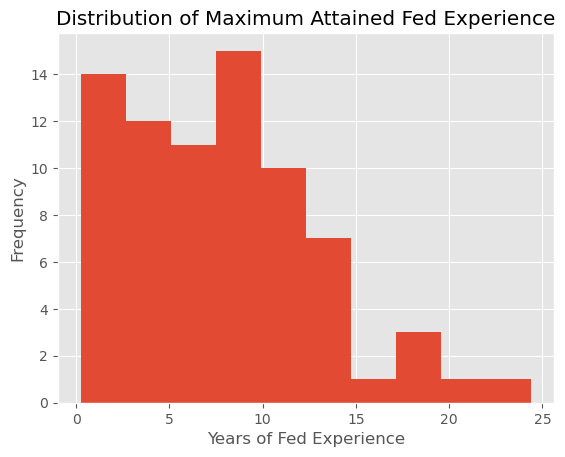

In [46]:
fig, ax = plt.subplots()
exp = tdf.groupby('speaker')['fed_exp'].max()
plt.style.use('ggplot')
ax.hist(exp)
ax.set_ylabel('Frequency')
ax.set_xlabel('Years of Fed Experience')
ax.set_title('Distribution of Maximum Attained Fed Experience')

In [62]:
len(tdf[tdf['date'].apply(lambda x : int(x.split('-')[0]) >= 1986) & tdf['date'].apply(lambda x : int(x.split('-')[0]) <= 2009)]['lname'].unique())

49

In [61]:
len(tdf['lname'].unique())

63

In [34]:
greenspan = tdf[tdf['lname'] == 'greenspan'] 
greenspan[['date', 'lname', 'fed_exp']].loc[1696:2000]

,date,lname,fed_exp
1696,1994-02-04,greenspan,6.490411
1726,1994-03-22,greenspan,6.616438
1750,1994-05-17,greenspan,6.769863
1774,1994-07-06,greenspan,6.906849
1800,1994-08-16,greenspan,7.019178
1825,1994-09-27,greenspan,7.134247
1852,1994-11-15,greenspan,7.268493
1879,1994-12-20,greenspan,7.364384
1905,1995-02-01,greenspan,7.482192
1936,1995-03-28,greenspan,7.632877


In [35]:
tdf

,date,speaker,text_enhanced,tokens,tprob_0,tprob_1,tprob_2,tprob_3,tprob_4,tprob_5,...,tprob_39,tprob_40,tprob_41,tprob_42,tprob_43,tprob_44,len,lname,is_fomc,fed_exp
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin...","['know', 'organiz', 'meet', 'alway', 'meet', '...",0.002360,0.001847,0.002183,0.080568,0.031129,0.001038,...,0.003070,0.001608,0.002960,0.023677,0.029818,0.001092,3330,greenspan,True,6.490411
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development...","['normal', 'econom', 'expans', 'develop', 'rea...",0.005527,0.006127,0.005889,0.045383,0.098863,0.003816,...,0.007200,0.006452,0.050246,0.017779,0.171482,0.004548,528,boehne,True,13.016438
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...,"['report', 'go', 'pretti', 'bland', 'develop',...",0.006002,0.012405,0.006998,0.094474,0.018949,0.003959,...,0.004729,0.005816,0.009277,0.005711,0.037993,0.006824,596,broaddus,True,1.093151
1703,1994-02-04,MR. FORRESTAL.,"Joan, do you have an ""add need"" tomorrow as we...","['joan', 'add', 'need', 'tomorrow', 'well', 'w...",0.020140,0.091074,0.006324,0.057786,0.028165,0.022221,...,0.007793,0.008051,0.013809,0.014129,0.091525,0.007299,655,forrestal,True,10.169863
1704,1994-02-04,MR. HOENIG.,"Mr. Chairman, our District continues to grow a...","['mr', 'chairman', 'district', 'continu', 'gro...",0.012011,0.040295,0.013197,0.111359,0.062660,0.007633,...,0.007634,0.013536,0.011957,0.016044,0.049795,0.009035,270,hoenig,True,2.347945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,2017-12-13,MR. WILLIAMS.,6 of the 16 have overshoots. This is a funny ...,"['overshoot', 'funni', 'convers', 'right', 'ok...",0.135822,0.002261,0.279552,0.002414,0.007210,0.002678,...,0.002361,0.010249,0.002208,0.002318,0.002693,0.006579,1464,williams,True,6.791781
6827,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...,"['think', 'norm', 'statement', 'think', 'forec...",0.045568,0.010675,0.471427,0.003058,0.002863,0.025499,...,0.026327,0.014143,0.003320,0.027396,0.008924,0.005177,1208,brainard,True,3.495890
6828,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla...","['lori', 'exhibit', 'chart', 'would', 'explain...",0.014065,0.006777,0.488591,0.002894,0.002737,0.021488,...,0.003726,0.011167,0.036839,0.011377,0.004289,0.047816,778,george,True,6.205479
6830,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from...","['thank', 'madam', 'chair', 'report', 'receiv'...",0.030459,0.003004,0.531640,0.002349,0.001780,0.002041,...,0.011612,0.003690,0.009766,0.015385,0.003107,0.004843,1231,mester,True,3.536986


In [36]:
tdf.to_csv('../working-csvs/fomc_w_topics.csv')